# Q-learning RL: Taylor-Green Flow

In [28]:
L = 2π # domain size
u0 = 1.0 # background velocity amplitude
k = 3.0 # background velocity wavenumber

xA = 2π/k # start point
yA = π/k
rA = 0.2

xB = 9π/(2k) # finish point
yB = 9π/(2k)
rB = 0.2

N_tile = 30 
δ = L/N_tile # grid size for tiling

Va = 0.1*u0 # agent's velocity
Δt = δ/(2*u0) # agent's reaction time
Na = 8 # number of actions

n_episodes = 5000 # number of episodes for evaluation
n_train = 20000 # number of episodes for training

T_free = sqrt((xB-xA)^2+(yB-yA)^2)/Va
T_max = 2*T_free

w_reward = 1.0 # weight in the reward function

velX(x,y) = u0*sin(k*x)*cos(k*y) # x-velocity
velY(x,y) = -u0*cos(k*x)*sin(k*y) # y-velocity
vort(x,y) = 2*u0*k*sin(k*x)*sin(k*y) # vorticity

# generate starting position
function start_point()
    ϕ = 2π*rand()
    r = rA*sqrt(rand())
    return xA+r*cos(ϕ), yA+r*sin(ϕ)
end

# checking that the agent did not hit the border or target
function is_terminal(x,y)
    if (x<=0)||(y<=0)||(x>=L)||(y>=L)
        return true
    elseif sqrt((xB-x)^2+(yB-y)^2)<=rB
        return true
    else
        return false
    end
end 

nothing

In [29]:
# here we integrate the equations of motion over an interval Δt
using OrdinaryDiffEq

function advection!(du, u, p, t)
    x, y = u
    θ = p
    du[1] = dx = velX(x,y) + Va*cos(θ)
    du[2] = dy = velY(x,y) + Va*sin(θ)
end

tspan = (0.0, Δt)

function next_state(x, y, θ)
    prob = ODEProblem(advection!, [x, y], tspan, θ)
    sol = solve(prob, Tsit5(), p = θ, reltol = 1e-8, abstol = 1e-8)
    return sol(Δt)[1], sol(Δt)[2]
end

nothing

In [30]:
# get the current state (s_x, s_y) based on the current position (x,y) 
function get_tile(x,y)
    return Int(ceil(x/δ)), Int(ceil(y/δ))
end

Q = zeros(N_tile, N_tile, Na) # Q-function [x-tile, y-tile, action]

# the set of possible actions Na=8 
actions = [-3π/4, -π/2, -π/4, 0, π/4, π/2, 3π/4, π]

# return greedy action
function choose_greedy_action(s_x::Int, s_y::Int)
    return actions[argmax(Q[s_x,s_y,:])]
end

# return ϵ-greedy action
function choose_action(s_x::Int, s_y::Int)
    if rand() < epsilon
        return actions[rand(1:Na)]
    else
        return actions[argmax(Q[s_x,s_y,:])]
    end
end

nothing

### RL Training

In [31]:
# we save total rewards
r_tracks = []

# learning rate for Q-function
α = 0.04

# adaptive epsilon (exp-decay with cut-off)
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.9995
epsilon = epsilon_start

for i in 1:n_train
    r_points = []
    
    # log to monitor training progress
    if i%5000==0
        println("i=",i)
    end

    # exp-decay with cut-off
    epsilon = max(epsilon_end, epsilon*epsilon_decay)
    
    x_now, y_now = start_point()
    step = 0
    
    while (is_terminal(x_now, y_now)==false)&&(step*Δt<T_max)        
        sx_now, sy_now = get_tile(x_now, y_now)
        θ_now = choose_action(sx_now,sy_now)
        action_num = round(Int,Na/2)+round(Int, Na*θ_now/(2*π))
       
        x_next, y_next = next_state(x_now, y_now, θ_now)
        step+=1
        
        reward = -Δt + w_reward*(sqrt((xB-x_now)^2+(yB-y_now)^2)/Va - sqrt((xB-x_next)^2+(yB-y_next)^2)/Va)
        
        # checking that the agent did not hit the border
        if (x_next<=0)||(y_next<=0)||(x_next>=L)||(y_next>=L)
            reward=reward-2*T_max
        end
        
        push!(r_points, reward)
        
        # Learning Part        
        sx_next, sy_next = get_tile(x_next, y_next)
        delta = reward
        
        if (sx_next>N_tile)||(sx_next<1)||(sy_next>N_tile)||(sy_next<1)
            delta = delta - Q[sx_now, sy_now, action_num]
        else
            delta = delta + maximum(Q[sx_next, sy_next, :]) - Q[sx_now, sy_now, action_num]
        end
                 
        Q[sx_now, sy_now, action_num] += α*delta
        
        x_now, y_now = x_next, y_next 
    end

    push!(r_tracks, sum(r_points))
    
end

i=5000
i=10000
i=15000
i=20000


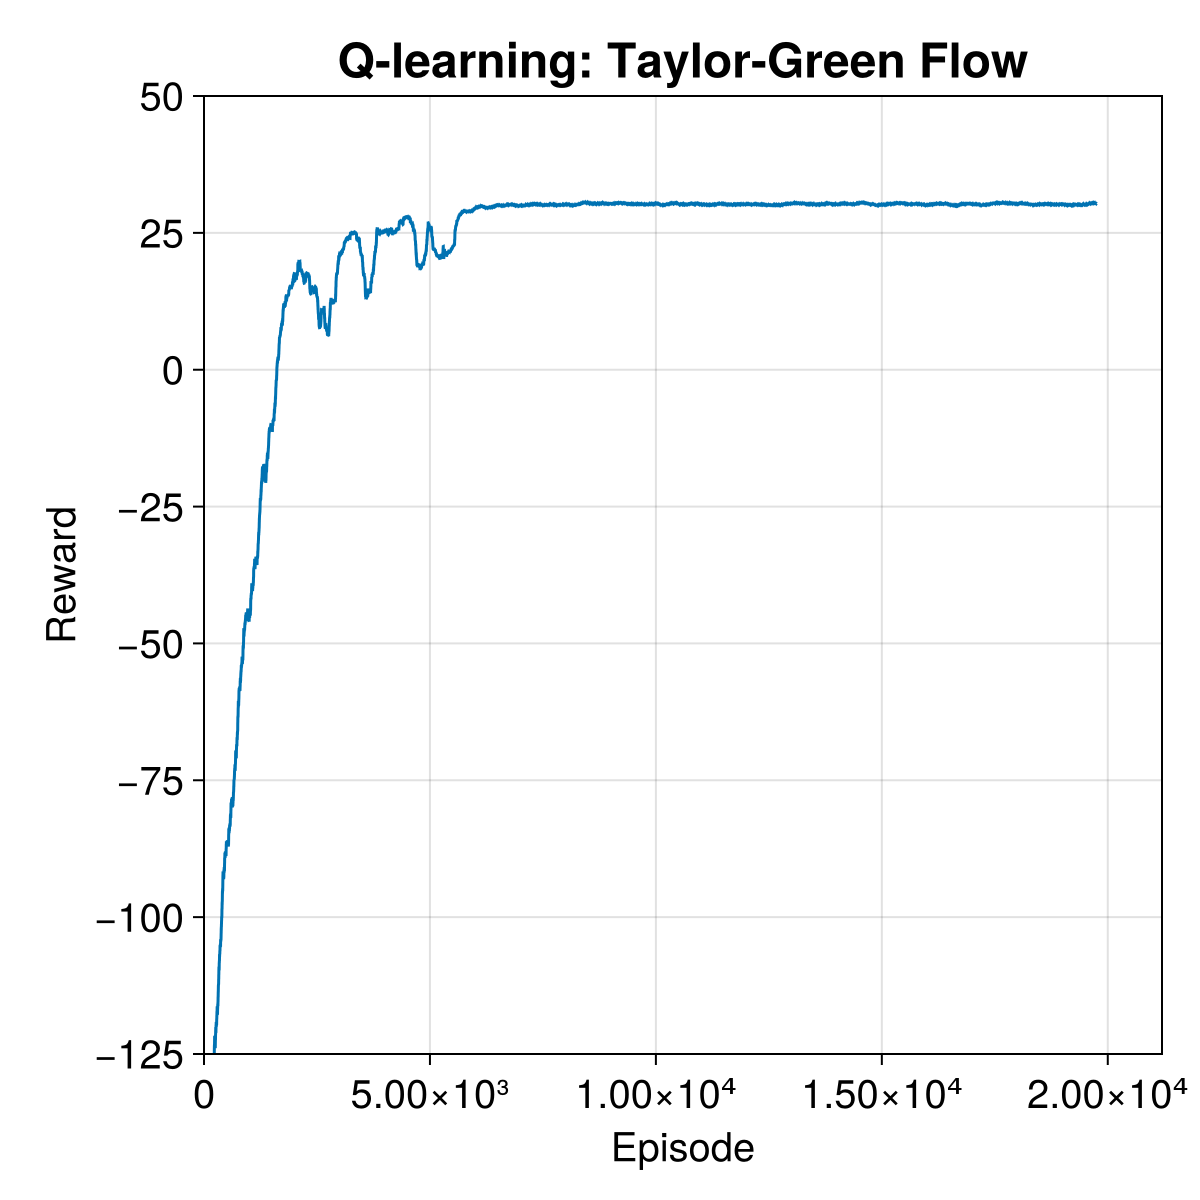

In [32]:
# Learning Progress: Reward vs. Episode Number
using CairoMakie

moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]

fig = Figure(size = (600, 600))

ax = Axis(fig[1, 1],
    title = "Q-learning: Taylor-Green Flow", titlesize=24,
    xlabel = "Episode", xlabelsize=20, xticklabelsize=20,
    ylabel = "Reward", ylabelsize=20, yticklabelsize=20,
    aspect = 1, limits = ((0, 1.06*n_train), (-125, 50))
)

lines!(ax, moving_average(r_tracks,250))

save("Taylor-Green + reward.pdf", fig)
fig

### Optimal Trajectory

In [33]:
function TG_advection!(du, u, p, t)
    x, y, z = u
    T = p[2]
    du[1] = dx = T*sin(3*x)*cos(3*y) + 0.1*T*cos(z)
    du[2] = dy = -T*cos(3*x)*sin(3*y) + 0.1*T*sin(z)
    du[3] = dz = 3*T*(sin(3*x)*sin(3*y)+cos(3*x)*cos(3*y)*sin(2*z))
end

# Simulation interval and intermediary points
tspan_opt = (0.0, 1.0)
tsteps_opt = 0.0:0.001:1.0

p_opt = [1.5607888077227354, 12.203803232024974]

prob_opt = ODEProblem(TG_advection!, [xA, yA, p_opt[1]], tspan_opt, p_opt)
opt_solution = solve(prob_opt, Tsit5(), p = p_opt, saveat = tsteps_opt,
                    reltol = 1e-8, abstol = 1e-8)

times = range(0, 1, length=200)
x_opt = [opt_solution(t)[1] for t in times]
y_opt = [opt_solution(t)[2] for t in times]

nothing

### Evaluation of Learned Policy

In [34]:
x_tracks_EV = []
y_tracks_EV = []
θ_tracks_EV = []
r_tracks_EV = []

success_EV = ones(n_episodes)

for i in 1:n_episodes
    x_points_EV = []
    y_points_EV = []
    θ_points_EV = []
    r_points_EV = []

    x_now, y_now = start_point()
    step = 0

    while (is_terminal(x_now, y_now)==false)&&(step*Δt<T_max)        
        sx_now, sy_now = get_tile(x_now, y_now)
        θ_now = choose_greedy_action(sx_now,sy_now)

        push!(x_points_EV, x_now)
        push!(y_points_EV, y_now)
        push!(θ_points_EV, θ_now)
        
        x_next, y_next = next_state(x_now, y_now, θ_now)
        step+=1
        
        reward = -Δt + w_reward*(sqrt((xB-x_now)^2+(yB-y_now)^2)/Va - sqrt((xB-x_next)^2+(yB-y_next)^2)/Va)
        
        if (x_next<=0)||(y_next<=0)||(x_next>=L)||(y_next>=L)
            reward=reward-2*T_max
            success_EV[i]=0
        elseif step*Δt>=T_max
            success_EV[i]=0
        end
        
        push!(r_points_EV, reward)
        
        x_now, y_now = x_next, y_next 
    end
    
    # end of episode
    if is_terminal(x_now, y_now)==true
        push!(x_points_EV, x_now)
        push!(y_points_EV, y_now)
    end

    push!(x_tracks_EV, x_points_EV)
    push!(y_tracks_EV, y_points_EV)
    push!(θ_tracks_EV, θ_points_EV)
    push!(r_tracks_EV, sum(r_points_EV))
    
end

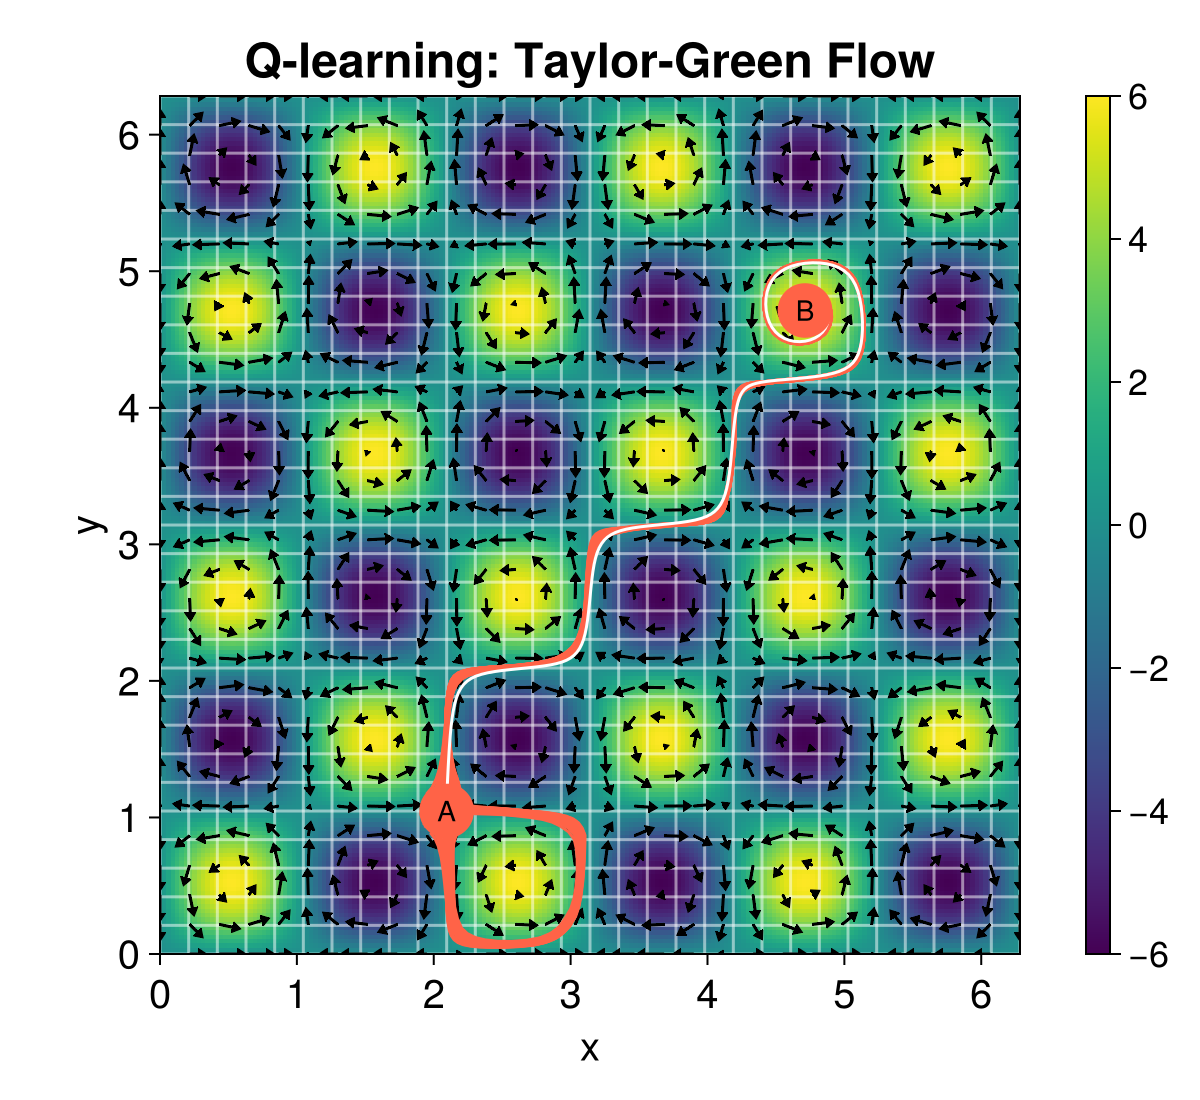

In [35]:
using CairoMakie

xs = range(0, L, length=200)
ys = range(0, L, length=200)
zs = [vort(x,y) for x in xs, y in ys]

xs2 = LinRange(0, L, N_tile)
ys2 = LinRange(0, L, N_tile)
us2 = [velX(x,y) for x in xs2, y in ys2]
vs2 = [velY(x,y) for x in xs2, y in ys2]

fig = Figure(size = (600, 550))

ax = Axis(fig[1, 1],
    title = "Q-learning: Taylor-Green Flow", titlesize=24,
    xlabel = "x", xlabelsize=20, xticklabelsize=20,
    ylabel = "y", ylabelsize=20, yticklabelsize=20,
    aspect = 1, limits = ((0, L), (0, L))
)

hm = heatmap!(ax, xs, ys, zs, colorrange=(-2*u0*k, 2*u0*k), colormap = :viridis, alpha=1.0)
Colorbar(fig[:, end+1], hm, ticklabelsize=18)

hlines!(ax, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)
vlines!(ax, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)

arrows2d!(ax, xs2, ys2, us2, vs2, lengthscale = 0.2, tiplength=4, tipwidth=6,
            shaftwidth=1.5, minshaftlength=0)

for i in 1:100
    lines!(ax, x_tracks_EV[i], y_tracks_EV[i], color=:tomato)
end

lines!(ax, x_opt, y_opt, color=:white)

poly!(ax, Circle(Point2f(xA, yA), rA), color = :tomato)
text!(xA, yA, text = "A", align = (:center, :center))

poly!(ax, Circle(Point2f(xB, yB), rB), color = :tomato)
text!(xB, yB, text = "B", align = (:center, :center))

save("Taylor-Green + tracks.pdf", fig)
fig

Fail Probabitity = 0.0
Average Reward = 30.324407968215656
Average Success Time = 12.896279730888146


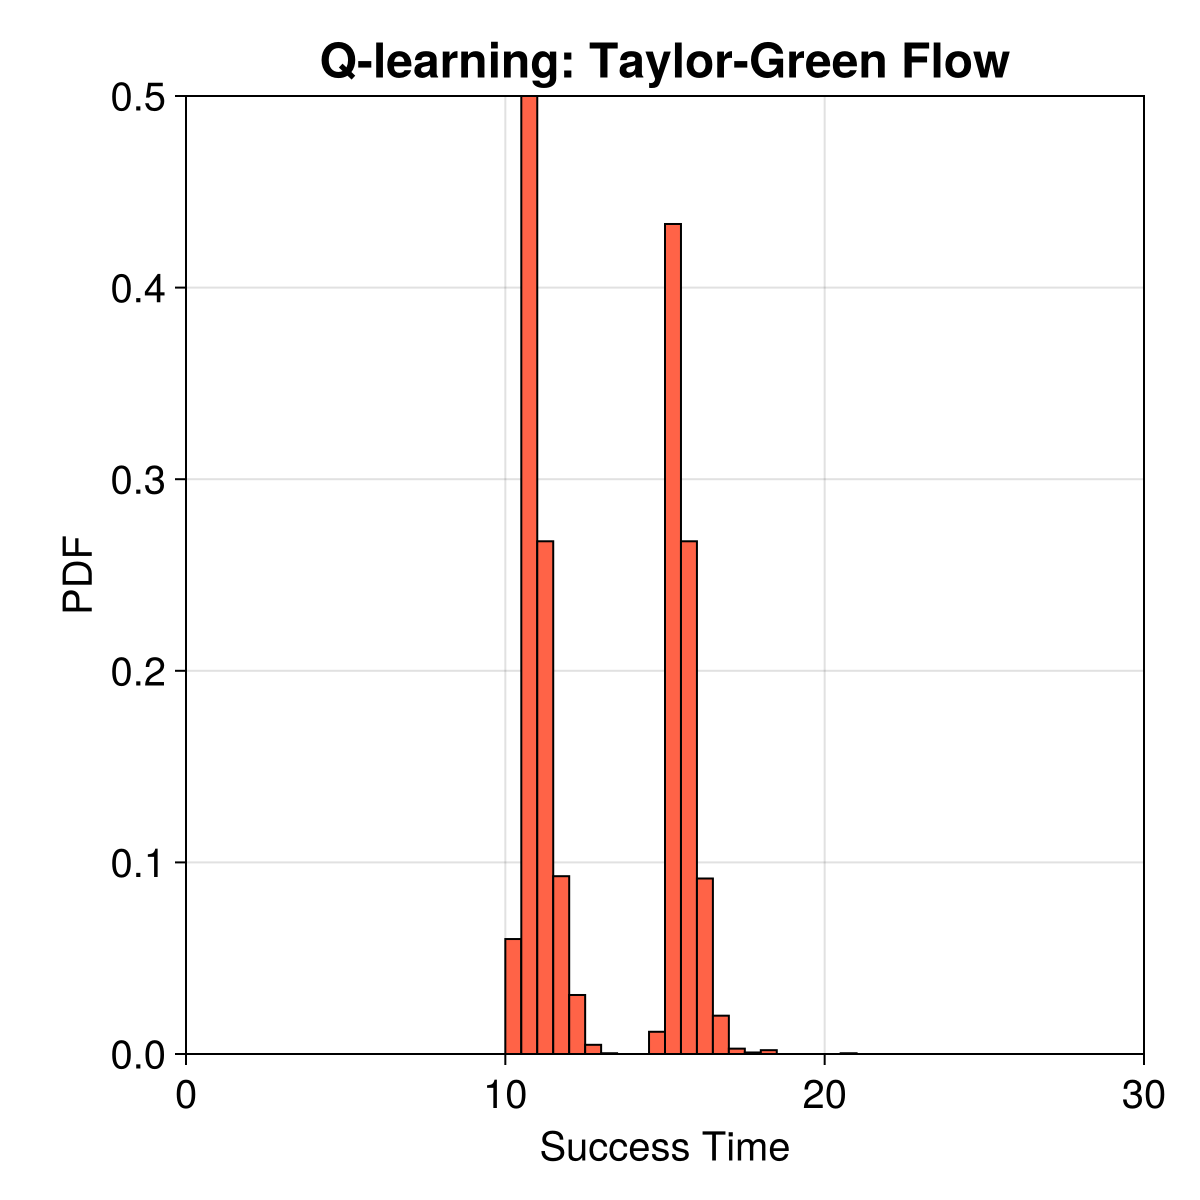

In [36]:
using Statistics

times_EV = zeros(Int(sum(success_EV)))
count_EV = 0

for i in 1:n_episodes
    if success_EV[i]==1
        count_EV+=1
        times_EV[count_EV] = length(x_tracks_EV[i])*Δt
    end
end
    
println("Fail Probabitity = ", 1-sum(success_EV)/n_episodes)
println("Average Reward = ", sum(r_tracks_EV)/n_episodes)
println("Average Success Time = ", mean(times_EV))

fig = Figure(size = (600, 600))

ax = Axis(fig[1, 1],
    title = "Q-learning: Taylor-Green Flow", titlesize=24,
    xlabel = "Success Time", xlabelsize=20, xticklabelsize=20,
    ylabel = "PDF", ylabelsize=20, yticklabelsize=20,
    aspect = 1, limits = ((0, 30), (0,0.5)),
)

hist!(ax, times_EV, normalization = :pdf, bins=0:0.5:30, strokewidth = 1,
        strokecolor = :black, color=:tomato)

save("Taylor-Green + success times.pdf", fig)
fig

In [37]:
# save results to file
using JLD2

jldsave("Q_data.jld2"; Q, r_tracks, x_tracks_EV, y_tracks_EV, θ_tracks_EV,
        r_tracks_EV, success_EV, times_EV) 